# Import modules

In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

In [2]:
import tissuetypist as tt

/software/cellgen/team205/kk18/envs/tissuetypist_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/software/cellgen/team205/kk18/envs/tissuetypist_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)

# Read in query data

In-house Xenium 5000plex dataset

In [4]:
path_to_adata = '/lustre/scratch126/cellgen/team205/kk18/xenium/objects/foetal/C194-HEA-0-FFPE-1_Hst45-HEA-0-FFPE-1_concat_5K_filtered_raw.h5ad'
adata = sc.read_h5ad(path_to_adata)
adata

AnnData object with n_obs × n_vars = 362277 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'tissue_block_id', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'fine_grain_8Dec2024', 'multi_celltypes_coarse', 'cluster_cellcharter', 'fine_grain_4Jan2025', 'sliding_window_assignment', 'globalX', 'globalY', 'predicted_labels_sliding_window_assignment', 'conf_score_sliding_window_assignmen

# Train with the gene panel of query dataset 

When predicting tissue types in imaging-based spatial transcriptomics data using a targeted gene panel (e.g., Xenium or MERFISH), we subset the reference Visium dataset to the panel’s genes and retrain the model accordingly.

### Preprocess reference dataframe with the gene panel

In [5]:
# Prepare list of genes in the panel of query dataset
gene_panel = list(adata.var_names)
print(len(gene_panel))
print(gene_panel[:5])

5001
['A2ML1', 'AAMP', 'AAR2', 'AARSD1', 'ABAT']


In [6]:
%%time
# preprocess
ref_df = tt.preprocess_builtin_reference(gene_panel=gene_panel,plot=False)
print(ref_df.shape)
ref_df.head()

Log-normalising reference data...


/software/cellgen/team205/kk18/envs/tissuetypist_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preparing expression data...
924 genes will be used.


/nfs/team205/kk18/github/TissueTypist/tissuetypist/preprocess.py:372: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for section, group_df in data.groupby('section'):


Calculating distance from tissue edge...
(19179, 1855)
CPU times: user 1.73 s, sys: 825 ms, total: 2.56 s
Wall time: 4.01 s


EGR3_own  PCNX3_own  USP32_own  \
spot_id                                                                 
HCAHeartST10298114_AAACAAGTATCTCCCA-1       0.0        0.0        0.0   
HCAHeartST10298114_AAACATTTCCCGGATT-1       0.0        0.0        0.0   
HCAHeartST10298114_AAACGAGACGGTTGAT-1       0.0        0.0        0.0   
HCAHeartST10298114_AAACTCGTGATATAAG-1       0.0        0.0        0.0   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1       0.0        0.0        0.0   

                                       APMAP_own  HCN4_own  NT5E_own  \
spot_id                                                                
HCAHeartST10298114_AAACAAGTATCTCCCA-1   0.000000   0.00000  1.661311   
HCAHeartST10298114_AAACATTTCCCGGATT-1   1.611682   0.00000  0.000000   
HCAHeartST10298114_AAACGAGACGGTTGAT-1   1.417540   1.41754  0.000000   
HCAHeartST10298114_AAACTCGTGATATAAG-1   2.276174   0.00000  0.000000   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1   0.000000   0.00000  0.000000   

                                       UGDH_own  OLFML3_own  SEZ6L_own  \
spot_id                                                                  
HCAHeartST10298114_AAACAAGTATCTCCCA-1  0.000000    2.254699        0.0   
HCAHeartST10298114_AAACATTTCCCGGATT-1  1.611682    2.199717        0.0   
HCAHeartST10298114_AAACGAGACGGTTGAT-1  0.000000    1.417540        0.0   
HCAHeartST10298114_AAACTCGTGATATAAG-1  1.158401    2.790788        0.0   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1  2.232105    1.327912        0.0   

                                       PDK1_own  ...  FSTL3_neighbour-max  \
spot_id                                          ...                        
HCAHeartST10298114_AAACAAGTATCTCCCA-1  0.000000  ...             0.000000   
HCAHeartST10298114_AAACATTTCCCGGATT-1  0.000000  ...             1.809050   
HCAHeartST10298114_AAACGAGACGGTTGAT-1  1.981541  ...             1.594878   
HCAHeartST10298114_AAACTCGTGATATAAG-1  0.000000  ...             3.014546   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1  1.878902  ...             1.711490   

                                       MDFIC_neighbour-max  \
spot_id                                                      
HCAHeartST10298114_AAACAAGTATCTCCCA-1             1.651021   
HCAHeartST10298114_AAACATTTCCCGGATT-1             1.593315   
HCAHeartST10298114_AAACGAGACGGTTGAT-1             1.651362   
HCAHeartST10298114_AAACTCGTGATATAAG-1             1.769002   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1             2.110092   

                                       PTGS1_neighbour-max  \
spot_id                                                      
HCAHeartST10298114_AAACAAGTATCTCCCA-1             0.000000   
HCAHeartST10298114_AAACATTTCCCGGATT-1             0.000000   
HCAHeartST10298114_AAACGAGACGGTTGAT-1             0.000000   
HCAHeartST10298114_AAACTCGTGATATAAG-1             2.084915   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1             0.000000   

                                                  section    x   y  \
spot_id                                                              
HCAHeartST10298114_AAACAAGTATCTCCCA-1  HCAHeartST10298114  102  50   
HCAHeartST10298114_AAACATTTCCCGGATT-1  HCAHeartST10298114   97  61   
HCAHeartST10298114_AAACGAGACGGTTGAT-1  HCAHeartST10298114   79  35   
HCAHeartST10298114_AAACTCGTGATATAAG-1  HCAHeartST10298114  113  23   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1  HCAHeartST10298114   67  45   

                                       n_neighbours  is_edge  \
spot_id                                                        
HCAHeartST10298114_AAACAAGTATCTCCCA-1           4.0    False   
HCAHeartST10298114_AAACATTTCCCGGATT-1           4.0    False   
HCAHeartST10298114_AAACGAGACGGTTGAT-1           4.0    False   
HCAHeartST10298114_AAACTCGTGATATAAG-1           4.0    False   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1           3.0     True   

                                       distance_to_edge  \
spot_id                                                   
HCAHeartST10298114_AAACAAGTATCTCCCA

The pre-processed dataframe includes:
* Gene expression data of each spot (suffix: `_own`)
* Gene expression data of neighbour spots (suffix: `_neighbour-max`)
* Section ID (`section`)
* XY coordinates (`x` and `y`)
* Distance to tissue edge (`distance_to_edge`)
* Tissue label (`tissue`)

### Train

In [7]:
%%time
dir_to_models = '/nfs/team205/kk18/notebooks/P48_Foetal-heart_Visium/notebooks/TissueTypist/tissuetypist_package_4/trained_models/Xenium5000'
tt.train(ref_df,
          tissue_col='tissue',
          save_dir=dir_to_models
         )

Training...: weight to neighbour spots = 0.0, weight to edge = 0
Training...: weight to neighbour spots = 0.3, weight to edge = 5
Training...: weight to neighbour spots = 1.0, weight to edge = 5
CPU times: user 2min 39s, sys: 876 ms, total: 2min 40s
Wall time: 2min 48s


# Predict

### Preprocess query data

Below, with setting as `pseudobulk=True`, we are generating pseudo-bulk gene expression data using a sliding window approach.
Specifically, the data will be segmented into adjacent windows to match the size of the low-resolution visium data, utilising the `squidpy.tl.sliding_window` function. For each defined window, gene expression data will be aggregated through summation. The resulting aggregated counts will be then normalized and log-transformed to prepare them for further pre-processing. 

Making pseudobulk per sliding window...
### Total window number ###: 21330
### Average cell number per window ###: 17.0
Pseudobulk: summed per window and log-normalised.
Preparing expression data...
924 genes will be used.
Calculating distance from tissue edge...


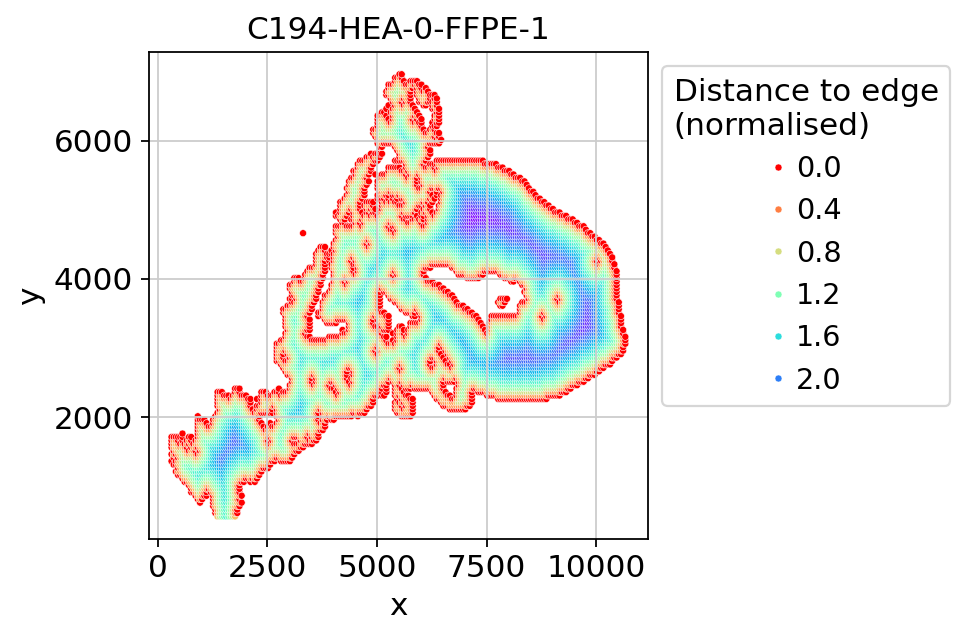

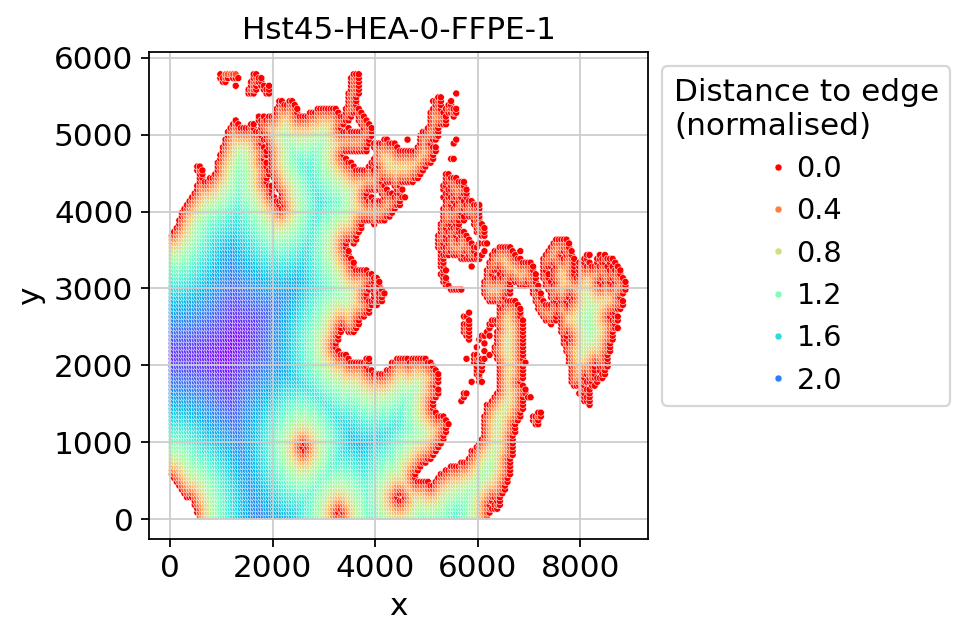

(21330, 1854)
CPU times: user 1min 58s, sys: 1.77 s, total: 2min
Wall time: 2min 5s


EGR3_own  PCNX3_own  USP32_own  APMAP_own  \
C194-HEA-0-FFPE-1_window_16       0.0        0.0        0.0        0.0   
C194-HEA-0-FFPE-1_window_18       0.0        0.0        0.0        0.0   
C194-HEA-0-FFPE-1_window_20       0.0        0.0        0.0        0.0   
C194-HEA-0-FFPE-1_window_21       0.0        0.0        0.0        0.0   
C194-HEA-0-FFPE-1_window_22       0.0        0.0        0.0        0.0   

                             HCN4_own  NT5E_own  UGDH_own  OLFML3_own  \
C194-HEA-0-FFPE-1_window_16   4.38658       0.0       0.0    0.000000   
C194-HEA-0-FFPE-1_window_18   0.00000       0.0       0.0    4.248003   
C194-HEA-0-FFPE-1_window_20   0.00000       0.0       0.0    0.000000   
C194-HEA-0-FFPE-1_window_21   0.00000       0.0       0.0    0.000000   
C194-HEA-0-FFPE-1_window_22   0.00000       0.0       0.0    0.000000   

                             SEZ6L_own  PDK1_own  ...  LOXL1_neighbour-max  \
C194-HEA-0-FFPE-1_window_16        0.0       0.0  ...                  0.0   
C194-HEA-0-FFPE-1_window_18        0.0       0.0  ...                  0.0   
C194-HEA-0-FFPE-1_window_20        0.0       0.0  ...                  0.0   
C194-HEA-0-FFPE-1_window_21        0.0       0.0  ...                  0.0   
C194-HEA-0-FFPE-1_window_22        0.0       0.0  ...                  0.0   

                             FSTL3_neighbour-max  MDFIC_neighbour-max  \
C194-HEA-0-FFPE-1_window_16                  0.0             0.000000   
C194-HEA-0-FFPE-1_window_18                  0.0             0.000000   
C194-HEA-0-FFPE-1_window_20                  0.0             0.000000   
C194-HEA-0-FFPE-1_window_21                  0.0             0.000000   
C194-HEA-0-FFPE-1_window_22                  0.0             3.241421   

                             PTGS1_neighbour-max            section  \
C194-HEA-0-FFPE-1_window_16             0.000000  C194-HEA-0-FFPE-1   
C194-HEA-0-FFPE-1_window_18             2.953963  C194-HEA-0-FFPE-1   
C194-HEA-0-FFPE-1_window_20             0.000000  C194-HEA-0-FFPE-1   
C194-HEA-0-FFPE-1_window_21             0.000000  C194-HEA-0-FFPE-1   
C194-HEA-0-FFPE-1_window_22             0.000000  C194-HEA-0-FFPE-1   

                                      x            y  n_neighbours  is_edge  \
C194-HEA-0-FFPE-1_window_16  312.770691  1359.514893           0.0     True   
C194-HEA-0-FFPE-1_window_18  312.770691  1459.514893           1.0     True   
C194-HEA-0-FFPE-1_window_20  312.770691  1559.514893           2.0     True   
C194-HEA-0-FFPE-1_window_21  312.770691  1609.514893           3.0     True   
C194-HEA-0-FFPE-1_window_22  312.770691  1659.514893           3.0     True   

                             distance_to_edge  
C194-HEA-0-FFPE-1_window_16               0.0  
C194-HEA-0-FFPE-1_window_18               0.0  
C194-HEA-0-FFPE-1_window_20               0.0  
C194-HEA-0-FFPE-1_window_21               0.0  
C194-HEA-0-FFPE-1_window_22               0.0  

[5 rows x 1854 columns]

In [8]:
%%time
query_df = tt.preprocess(adata,
                     section_col='tissue_block_id',
                     coord_columns = None,
                     pseudobulk=True,
                     pseudobulk_window_size=50,
                     tile_type='square', # 'hexagon' or 'square'
                     plot=True
                    )
print(query_df.shape)
query_df.head()

### Predict

In [9]:
%%time
query_df = tt.predict(query_df,
                  pipeline_dir=dir_to_models
                 )

Loading custom models...
Loading custom models...
Loading custom models...
##### weight2neighbours-0.0_weight2edge-0 #####
number of features: 1849
predicting...
done!
##### weight2neighbours-0.3_weight2edge-5 #####
number of features: 1849
predicting...
done!
##### weight2neighbours-1.0_weight2edge-5 #####
number of features: 1849
predicting...
done!
CPU times: user 1.39 s, sys: 1.05 s, total: 2.44 s
Wall time: 2.57 s


# Plot results

In [10]:
AnnotationPalette={ 
    'Atrium':'#eac075',
        'Ventricle - Compact':'#f1acfa',
     'Ventricle - Trabeculated':'#f09951',
        'SAnode':'#8A2BE2',
        'AVnode':'#062b4a',
    'VCS - Proximal':'#FFFF00',
        'VCS - Distal':'#7FFFD4',
        'Epicardium':'#01ccc8',
        'Endocardium - Atrial':'#DC143C',
        'Endocardium - Ventricular':'#f53527',
        'Endocardial cusion':'#ff7e97',
        'Great vessel':'#ff9b6e',
    'Ductus arteriosus':'#8a6800',
        'Coronary vessel':'#206601',
        'Adventitia - Coronary':'#CAFF70',
     'Adventitia - GV':'#005aa0',
        'AV ring':'#e478ff',
    'Valves':'#3300FF',
    'LN':'#9088ff',
}

number of sections: 2


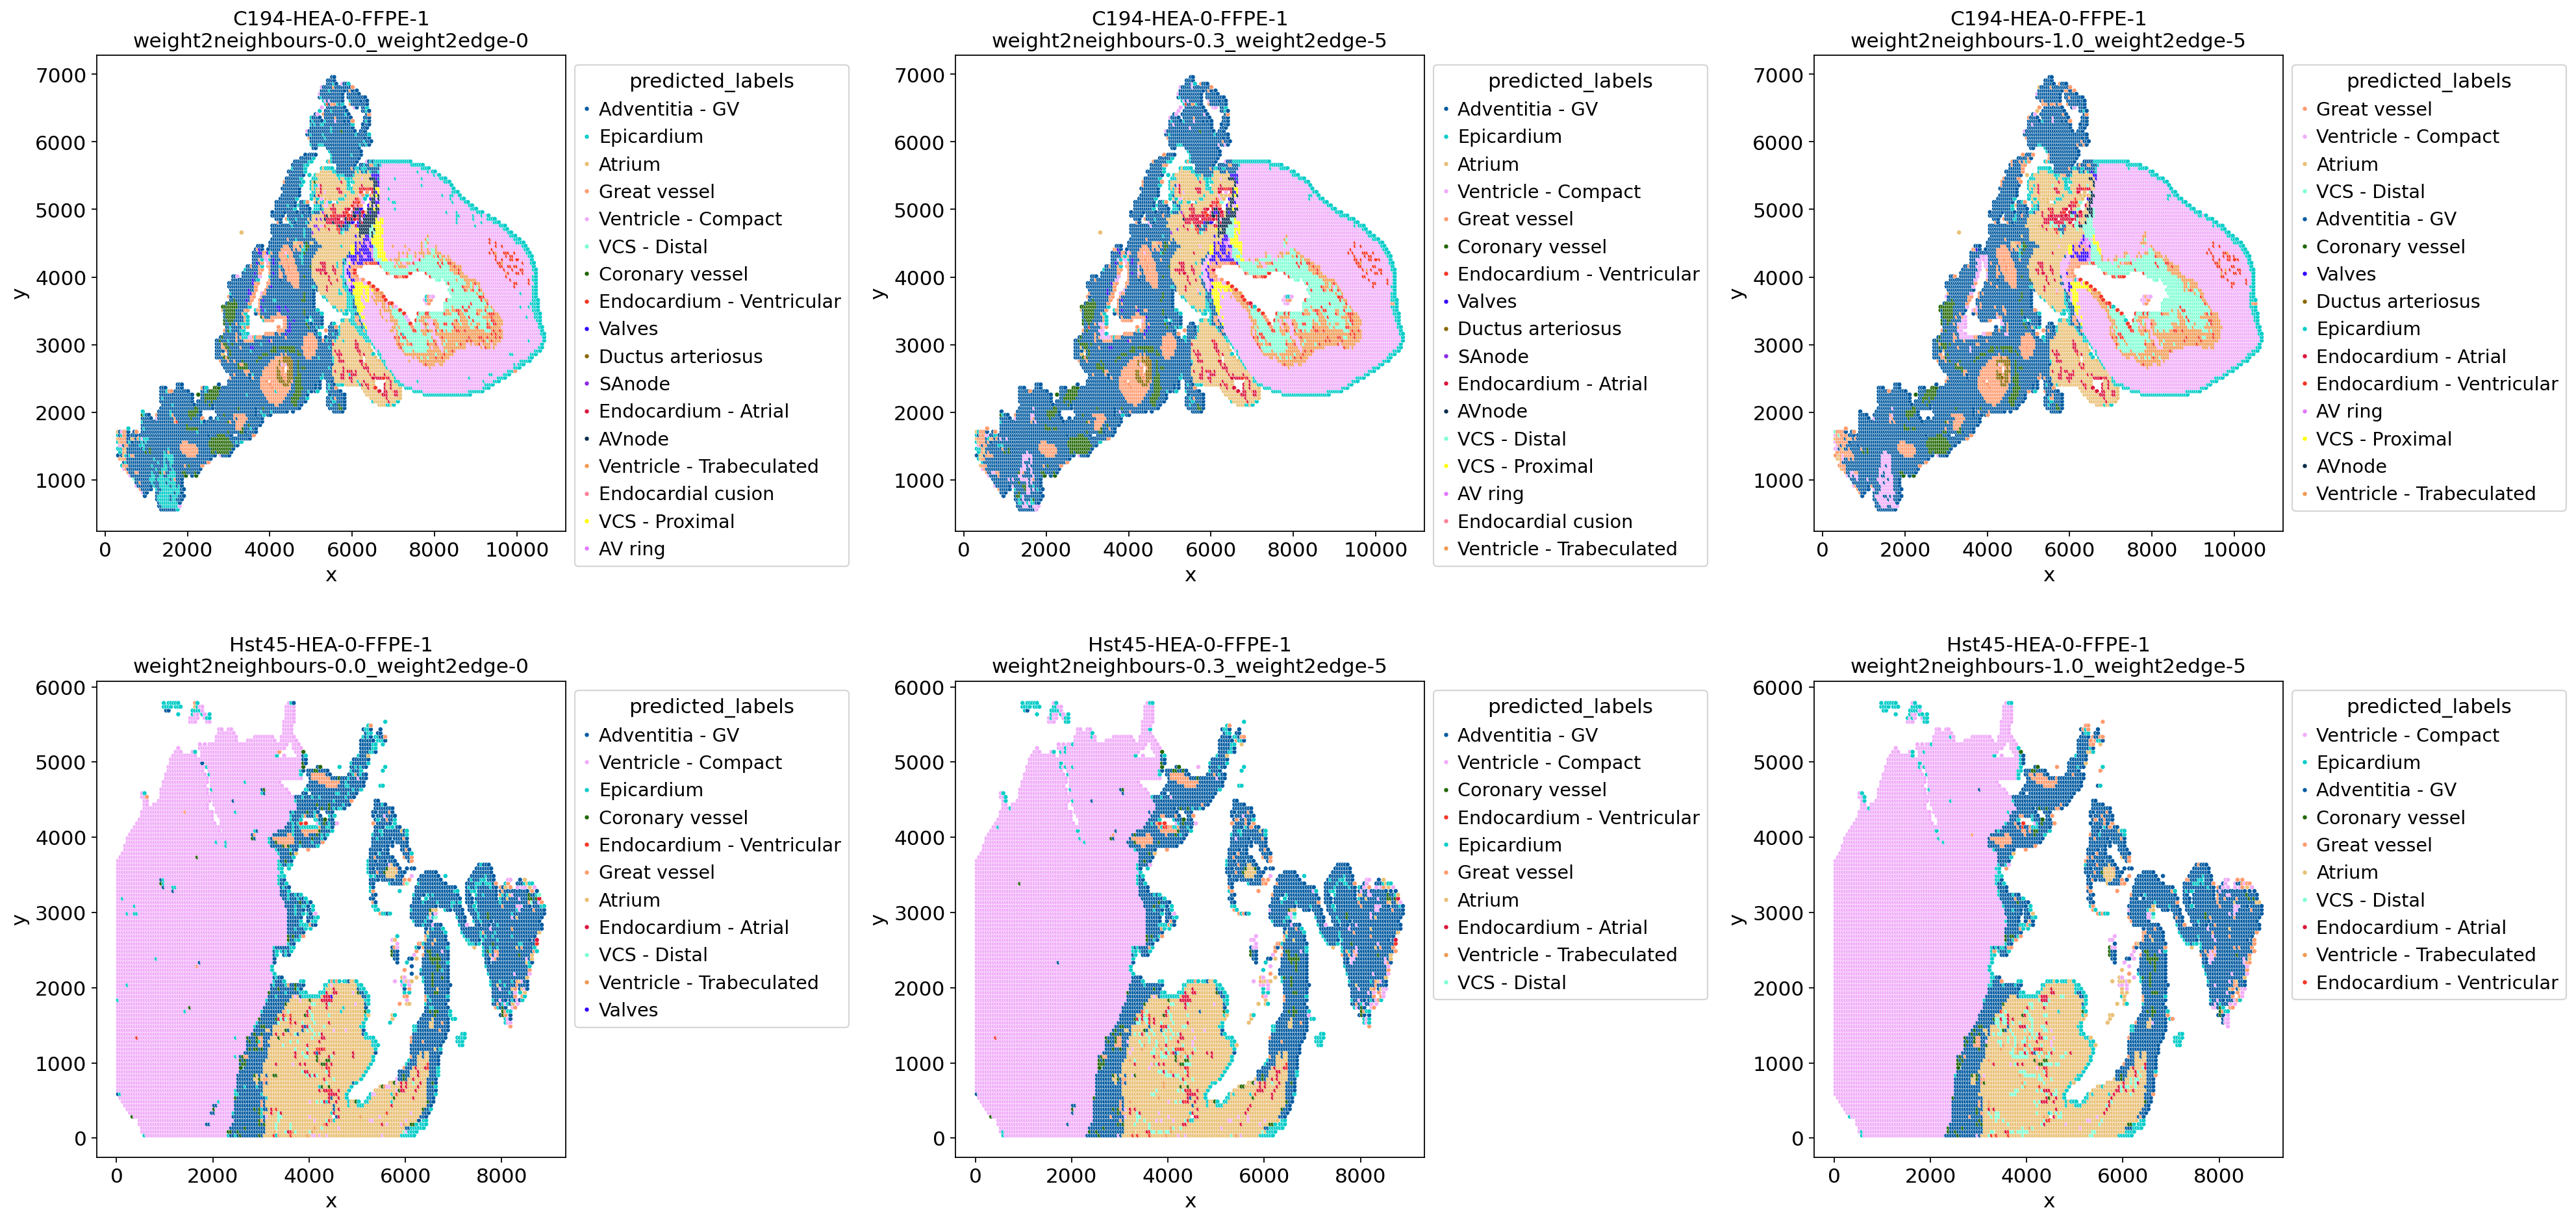

In [11]:
sections = set(query_df['section'])
print(f'number of sections: {len(sections)}')
predictions = [x for x in query_df.columns if 'predicted_labels_' in x]

plt.rcParams['axes.grid'] = False
fig, axs = plt.subplots(ncols=3,nrows=len(sections),figsize=(25,6*len(sections)))
axs = axs.flatten()
count=0
for i,section in enumerate(sections):
    # subset
    data_sub = query_df[query_df['section']==section]
    for j,col in enumerate(predictions):
        count = (i*3)+j
        pipeline_name = col.replace('predicted_labels_','')
        sns.scatterplot(
            x='x',y='y',hue=col,
            data=data_sub,
            s=10,palette=AnnotationPalette,ax=axs[count]
        )
        axs[count].set_title(f'{section}\n{pipeline_name}')
        axs[count].legend(title='predicted_labels',bbox_to_anchor=(1, 1))
fig.tight_layout()

# Select a condition and store the output to the original adata

In [12]:
adata = tt.prediction_to_adata(adata,
                         query_df,
                         weight_neighbour=0.3,
                         weight_edge=5,
                         sliding_window_col='sliding_window_assignment')
adata.obs

0 data don't have a predicted result


cell_id   x_centroid   y_centroid  \
C194-HEA-0-FFPE-1_aaaafiob-1   aaaafiob-1   782.026245  1025.860474   
C194-HEA-0-FFPE-1_aaaajopp-1   aaaajopp-1   784.114746  1034.308350   
C194-HEA-0-FFPE-1_aaaanald-1   aaaanald-1   791.200500  1028.298462   
C194-HEA-0-FFPE-1_aaabdjka-1   aaabdjka-1   819.555664  1032.847168   
C194-HEA-0-FFPE-1_aaabglmg-1   aaabglmg-1   819.384583  1007.732910   
...                                   ...          ...          ...   
Hst45-HEA-0-FFPE-1_oigcomgh-1  oigcomgh-1  1978.174805  2983.611572   
Hst45-HEA-0-FFPE-1_oigeappc-1  oigeappc-1  2074.796875  3043.838379   
Hst45-HEA-0-FFPE-1_oigeiifh-1  oigeiifh-1  2077.137451  3027.821777   
Hst45-HEA-0-FFPE-1_oigeklem-1  oigeklem-1  2031.117554  2911.677979   
Hst45-HEA-0-FFPE-1_oigenchi-1  oigenchi-1  2075.489746  2908.141357   

                               transcript_counts  control_probe_counts  \
C194-HEA-0-FFPE-1_aaaafiob-1                 754                     0   
C194-HEA-0-FFPE-1_aaaajopp-1                 145                     0   
C194-HEA-0-FFPE-1_aaaanald-1                 569                     0   
C194-HEA-0-FFPE-1_aaabdjka-1                 659                     0   
C194-HEA-0-FFPE-1_aaabglmg-1                  83                     0   
...                                          ...                   ...   
Hst45-HEA-0-FFPE-1_oigcomgh-1                 66                     0   
Hst45-HEA-0-FFPE-1_oigeappc-1                 70                     0   
Hst45-HEA-0-FFPE-1_oigeiifh-1                450                     0   
Hst45-HEA-0-FFPE-1_oigeklem-1                316                     0   
Hst45-HEA-0-FFPE-1_oigenchi-1                127                     0   

                               genomic_control_counts  \
C194-HEA-0-FFPE-1_aaaafiob-1                        0   
C194-HEA-0-FFPE-1_aaaajopp-1                        0   
C194-HEA-0-FFPE-1_aaaanald-1                        0   
C194-HEA-0-FFPE-1_aaabdjka-1                        0   
C194-HEA-0-FFPE-1_aaabglmg-1                        0   
...                                               ...   
Hst45-HEA-0-FFPE-1_oigcomgh-1                       0   
Hst45-HEA-0-FFPE-1_oigeappc-1                       0   
Hst45-HEA-0-FFPE-1_oigeiifh-1                       0   
Hst45-HEA-0-FFPE-1_oigeklem-1                       0   
Hst45-HEA-0-FFPE-1_oigenchi-1                       0   

                               control_codeword_counts  \
C194-HEA-0-FFPE-1_aaaafiob-1                         0   
C194-HEA-0-FFPE-1_aaaajopp-1                         0   
C194-HEA-0-FFPE-1_aaaanald-1                         0   
C194-HEA-0-FFPE-1_aaabdjka-1                         0   
C194-HEA-0-FFPE-1_aaabglmg-1                         0   
...                                                ...   
Hst45-HEA-0-FFPE-1_oigcomgh-1                        0   
Hst45-HEA-0-FFPE-1_oigeappc-1                        0   
Hst45-HEA-0-FFPE-1_oigeiifh-1                        0   
Hst45-HEA-0-FFPE-1_oigeklem-1                        0   
Hst45-HEA-0-FFPE-1_oigenchi-1                        0   

                               unassigned_codeword_counts  \
C194-HEA-0-FFPE-1_aaaafiob-1                            0   
C194-HEA-0-FFPE-1_aaaajopp-1                            0   
C194-HEA-0-FFPE-1_aaaanald-1                            0   
C194-HEA-0-FFPE-1_aaabdjka-1                            1   
C194-HEA-0-FFPE-1_aaabglmg-1                            0   
...                                                   ...   
Hst45-HEA-0-FFPE-1_oigcomgh-1                           0   
Hst45-HEA-0-FFPE-1_oigeappc-1                           0   
Hst45-HEA-0-FFPE-1_oigeiifh-1                           0   
Hst45-HEA-0-FFPE-1_oigeklem-1                           0   
Hst45-HEA-0-FFPE-1_oigenchi-1                           0   

                               deprecated_codeword_counts  total_counts  ...  \
C194-HEA-0-FFPE-1_aaaafiob-1                            0         754.0  ...   
C194-HEA-0-FFPE-1

In [13]:
# save adata
adata.write(path_to_adata)
path_to_adata

'/lustre/scratch126/cellgen/team205/kk18/xenium/objects/foetal/C194-HEA-0-FFPE-1_Hst45-HEA-0-FFPE-1_concat_5K_filtered_raw.h5ad'